In [ ]:
%%capture
# Install necessary libraries
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install pillow matplotlib numpy transformers open3d opencv-python

# Import libraries
from matplotlib import pyplot as plt
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import numpy as np
import open3d as o3d
import os
from google.colab import files

#getting model
feature_extractor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")


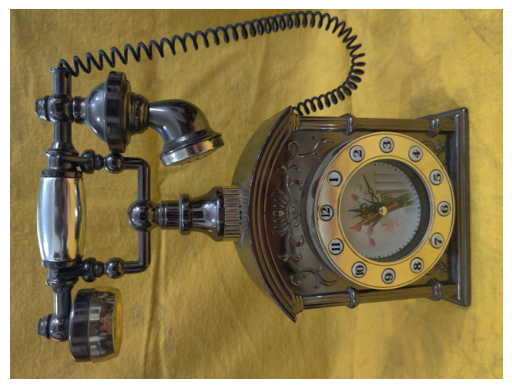

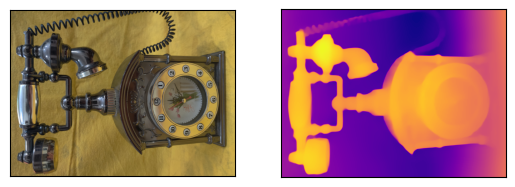

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[Open3D WARNING] Write OBJ can not include triangle normals.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Point cloud generation from depth map
def create_point_cloud(depth_map, img_rgb_resized):
    h, w = depth_map.shape
    fx = fy = w / 2  # Focal length approximation
    cx = w / 2
    cy = h / 2

    points = []
    colors = []

    for v in range(h):
        for u in range(w):
            z = depth_map[v, u]
            if z > 0:
                x = (u - cx) * z / fx
                y = (v - cy) * z / fy
                points.append([x, y, z])
                colors.append(img_rgb_resized[v, u] / 255.0)

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(np.array(points))
    point_cloud.colors = o3d.utility.Vector3dVector(np.array(colors))

    return point_cloud



#Loading and resizing the image
image_input = Image.open("/content/images.jpeg")
texture_image = image_input

diff = 0
new_height = 480 if image_input.height > 480 else image_input.height
new_height -= (new_height % 32)
new_width = int(new_height * image_input.width / image_input.height)
diff -= new_width % 32
new_width = new_width - diff if diff < 16 else new_width + 32 - diff
new_size = (new_width, new_height)
image_resized = image_input.resize(new_size)

# Display the image
plt.imshow(image_resized)
plt.axis('off')  # Hide axes for better visualization
plt.show()

inputs = feature_extractor(images=image_resized, return_tensors="pt")

#Getting the predictions from the model
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth


#post processing
pad = 16
output = predicted_depth.squeeze().cpu().numpy() * 1000.0
output = output[pad:-pad, pad:-pad]
image_post = image_resized.crop((pad, pad, image_resized.width - pad, image_resized.height - pad))


#visualizing the prediction
fig, ax = plt.subplots(1, 2)  # Create 1 row and 2 columns of subplots
ax[0].imshow(image_post)
ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax[1].imshow(output, cmap="plasma")
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.show()

#preparing the depth image for open3d
width, height = image_post.size
depth_image = (output * 255 / np.max(output)).astype("uint8")
image = np.array(image_post)


# Convert depth image to a Pillow Image and resize it
depth_image_pil = Image.fromarray(depth_image)
rgb_image_pil = Image.fromarray(image)

# Resize both images to match dimensions (use the smaller size)
target_size = (min(depth_image_pil.width, rgb_image_pil.width), min(depth_image_pil.height, rgb_image_pil.height))

# Resize both images to the target size
depth_resized = depth_image_pil.resize(target_size)
rgb_resized = rgb_image_pil.resize(target_size)

# Convert back to NumPy arrays
depth_resized = np.asarray(depth_resized)
rgb_resized = np.asarray(rgb_resized)

# Convert the resized images to Open3D format
depth_o3d = o3d.geometry.Image(depth_resized)
rgb_o3d = o3d.geometry.Image(rgb_resized)

# Now create the RGBD image
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_o3d, depth_o3d, convert_rgb_to_intensity=False)

#creating camera
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 500, 500, width/2, height/2)


#creating the point cloud
pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
o3d.io.write_point_cloud("point_cloud.ply", pcd_raw)
# files.download("point_cloud.ply")



# Generate and visualize point cloud
point_cloud = create_point_cloud(depth_resized, rgb_resized)
# Save point cloud to file
o3d.io.write_point_cloud("point_cloud.ply", point_cloud)


# Estimate normals for the point cloud
point_cloud.estimate_normals()

# Orient the normals consistently
point_cloud.orient_normals_consistent_tangent_plane(100)

# Mesh generation from point cloud using Poisson reconstruction
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
    point_cloud, depth=8
)

# Save the mesh to a file
o3d.io.write_triangle_mesh("mesh.ply", mesh)

# Download the mesh
files.download("mesh.ply")

# Ensure the densities array size matches the number of vertices
if len(densities) > len(mesh.vertices):
    # Trim the densities array to match the number of vertices
    densities = densities[:len(mesh.vertices)]

# Create a mask for low-density vertices
vertices_to_remove = densities < np.quantile(densities, 0.01)

# Remove the low-density vertices
mesh.remove_vertices_by_mask(vertices_to_remove)

# Save the cleaned mesh to a file
o3d.io.write_triangle_mesh("cleaned_mesh.ply", mesh)

# Download the cleaned mesh
files.download("cleaned_mesh.ply")

texture_image = texture_image.convert("RGB")  # Convert to RGB if needed

# Load your 3D mesh model (generated from the depth map)
# mesh = o3d.io.read_triangle_mesh("/content/mesh.ply")

mesh.compute_vertex_normals()
mesh.textures = [o3d.geometry.Image(np.array(texture_image))]

mesh.compute_vertex_normals()
o3d.io.write_triangle_mesh("textured_mesh.obj", mesh, write_vertex_normals=True)

files.download("textured_mesh.obj")